In [1]:
import pymc3 as pm
import numpy as np
import theano
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore')

In [3]:
NUM_SAMPLES = 1000

In [4]:
# Helper function to convert evidence dictionary to a string
def map_to_string(map):
    keys = list(map.keys())
    map_string = "{" + ", ".join([f"{key}: {map[key]}" for key in keys]) + "}"
    return map_string

In [5]:
# Generative model
def data_breach_model(controls_improvement, pen_test_prob, audit):
    
    data_breach_prob = (
        0.9 if (pen_test and audit) else
        0.5 if ((pen_test and not audit) or (not pen_test and audit)) else
        0.1  # Probability for some other cause not in the model
    )
    data_breach = pm.Bernoulli('data_breach', data_breach_prob)
    
    return {"data_breach": data_breach, "pen_test": pen_test, "audit": audit, "controls_improvement": controls_improvement}

In [6]:
# Evidence
evidence = {"controls_improvement": 0, "pen_test": 1}

In [7]:
with pm.Model() as model:
    # Model variables
    controls_improvement = pm.Bernoulli('controls_improvement', 0.5)
    pen_test = pm.Bernoulli('pen_test', 0.8 if controls_improvement else 0.2)
    audit = pm.Bernoulli('audit', 0.1 if controls_improvement else 0.5)

    # Model data_breach based on pen_test and audit
    data_breach_vars = data_breach_model(controls_improvement, pen_test, audit)
        
    # Apply evidence
    if "audit" in evidence:
        pm.Potential('obs_audit', pm.math.switch(pm.math.eq(audit, int(evidence["audit"])), 0, -np.inf))
    if "pen_test" in evidence:
        pm.Potential('obs_pen_test', pm.math.switch(pm.math.eq(pen_test, int(evidence["pen_test"])), 0, -np.inf))
    if "controls_strength" in evidence:
        pm.Potential('obs_controls_strength', pm.math.switch(pm.math.eq(controls_strength, int(evidence["controls_strength"])), 0, -np.inf))
    if "data_breach" in evidence:
        pm.Bernoulli('obs_data_breach', p=data_breach_vars["data_breach"], observed=int(evidence["data_breach"]))

    trace = pm.sample(NUM_SAMPLES, tune=1000)


Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [controls_improvement, pen_test, audit, data_breach]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<Axes: title={'center': 'controls_improvement'}>,
        <Axes: title={'center': 'controls_improvement'}>],
       [<Axes: title={'center': 'pen_test'}>,
        <Axes: title={'center': 'pen_test'}>],
       [<Axes: title={'center': 'audit'}>,
        <Axes: title={'center': 'audit'}>],
       [<Axes: title={'center': 'data_breach'}>,
        <Axes: title={'center': 'data_breach'}>]], dtype=object)

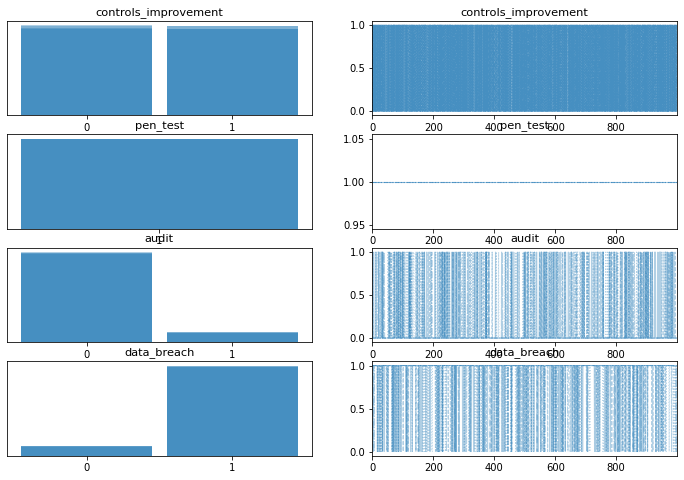

In [8]:
# Display results
pm.traceplot(trace)

Got error No model on context stack. trying to find log_likelihood in translation.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

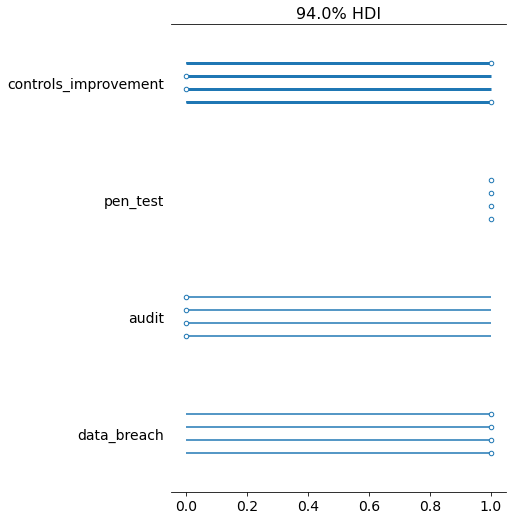

In [9]:
pm.forestplot(trace)

In [10]:
# Print the summary
summary = pm.summary(trace, var_names=['data_breach'])
print(summary)

Got error No model on context stack. trying to find log_likelihood in translation.


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
data_breach  0.905  0.293     0.0      1.0      0.005    0.004    3101.0   

             ess_tail  r_hat  
data_breach    3101.0    1.0  


In [11]:
# Generative model
def data_breach_model(controls_improvement, pen_test_prob, audit):
    pen_test = pm.Bernoulli('pen_test', pen_test_prob)
    
    data_breach_prob = (
        0.9 if (pen_test and audit) else
        0.5 if ((pen_test and not audit) or (not pen_test and audit)) else
        0.1  # Probability for some other cause not in the model
    )
    data_breach = pm.Bernoulli('data_breach', data_breach_prob)
    
    return {"data_breach": data_breach, "pen_test": pen_test, "audit": audit, "controls_improvement": controls_improvement}

In [12]:
# Updated Evidence
evidence = {"controls_improvement": 0, "pen_test_prob": 0.8, "audit": 0}

In [13]:
with pm.Model() as model:
    # Model variables with explicit initialization
    controls_improvement = pm.Bernoulli('controls_improvement', 0.5, initval=evidence.get('controls_improvement', 0))
    pen_test_prob = pm.Beta('pen_test_prob', alpha=2, beta=5, initval=evidence.get('pen_test_prob', 0.8))
    audit = pm.Bernoulli('audit', 0.1 if controls_improvement else 0.5, initval=evidence.get('audit', 1))

    # Model data_breach based on pen_test and audit
    data_breach_vars = data_breach_model(controls_improvement, pen_test_prob, audit)
    
    # Apply evidence
    if "audit" in evidence:
        pm.Potential('obs_audit', pm.math.switch(pm.math.eq(audit, int(evidence["audit"])), 0, -np.inf))
    if "pen_test_prob" in evidence:
        pm.Potential('obs_pen_test_prob', pm.math.switch(pm.math.eq(pen_test_prob, evidence["pen_test_prob"]), 0, -np.inf))
    if "controls_improvement" in evidence:
        pm.Potential('obs_controls_improvement', pm.math.switch(pm.math.eq(controls_improvement, int(evidence["controls_improvement"])), 0, -np.inf))
    
    # use the NUTS sampler and adjust the target_accept parameter to potentially improve sampling
    step = pm.NUTS(target_accept=0.9)
    
    # Manual initialization in an attempt to find a good starting point for the parameters. 
    start = pm.find_MAP()
    
    trace = pm.sample(NUM_SAMPLES, tune=1000, init='auto', start=start, step=pm.Metropolis())

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [data_breach]
>Metropolis: [pen_test]
>Metropolis: [audit]
>Metropolis: [pen_test_prob]
>Metropolis: [controls_improvement]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<Axes: title={'center': 'controls_improvement'}>,
        <Axes: title={'center': 'controls_improvement'}>],
       [<Axes: title={'center': 'audit'}>,
        <Axes: title={'center': 'audit'}>],
       [<Axes: title={'center': 'pen_test'}>,
        <Axes: title={'center': 'pen_test'}>],
       [<Axes: title={'center': 'data_breach'}>,
        <Axes: title={'center': 'data_breach'}>],
       [<Axes: title={'center': 'pen_test_prob'}>,
        <Axes: title={'center': 'pen_test_prob'}>]], dtype=object)

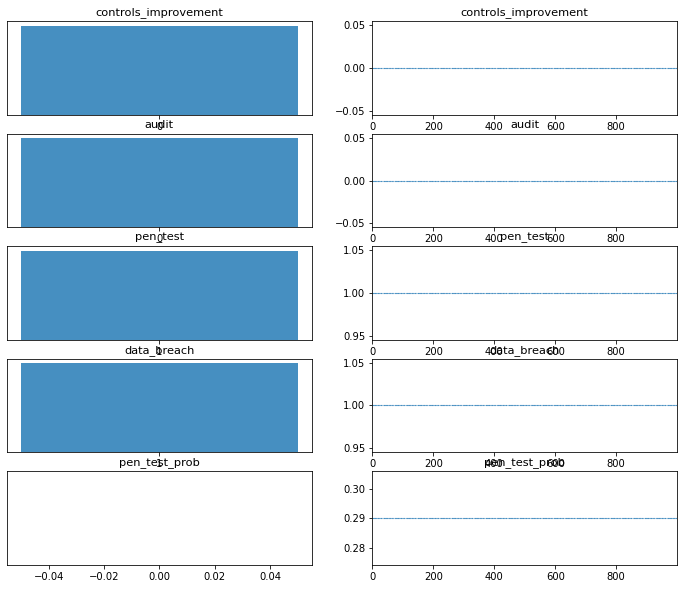

In [14]:
# Display results
pm.traceplot(trace)

Got error No model on context stack. trying to find log_likelihood in translation.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

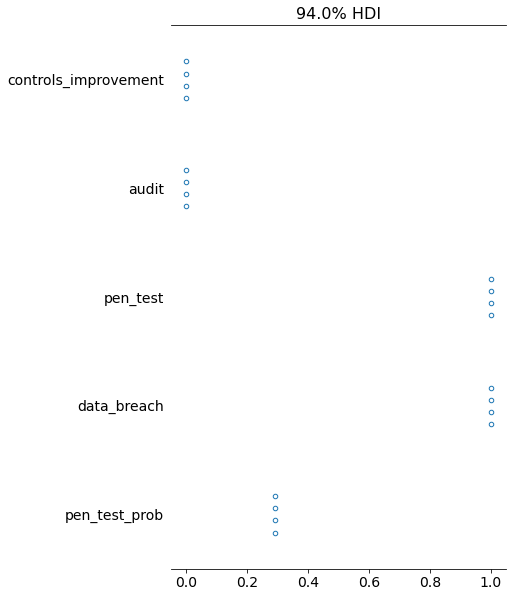

In [15]:
pm.forestplot(trace)

In [16]:
# Print the summary
summary = pm.summary(trace, var_names=['data_breach'])
print(summary)

Got error No model on context stack. trying to find log_likelihood in translation.


             mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
data_breach   1.0  0.0     1.0      1.0        0.0      0.0    4000.0   

             ess_tail  r_hat  
data_breach    4000.0    NaN  


In [17]:
with pm.Model() as model:
    # Model variables with automatic initialization
    controls_improvement = pm.Bernoulli('controls_improvement', 0.5, testval=evidence.get('controls_improvement', 0))
    pen_test_prob = pm.Beta('pen_test_prob', alpha=2, beta=5, testval=evidence.get('pen_test_prob', 0.9))
    audit = pm.Bernoulli('audit', 0.1 if controls_improvement else 0.5, testval=evidence.get('audit', 1))

    # Model data_breach based on pen_test and audit
    data_breach_vars = data_breach_model(controls_improvement, pen_test_prob, audit)
    
    # Apply evidence
    if "audit" in evidence:
        pm.Potential('obs_audit', pm.math.switch(pm.math.eq(audit, int(evidence["audit"])), 0, -np.inf))
    if "pen_test_prob" in evidence:
        pm.Potential('obs_pen_test_prob', pm.math.switch(pm.math.eq(pen_test_prob, evidence["pen_test_prob"]), 0, -np.inf))
    if "controls_improvement" in evidence:
        pm.Potential('obs_controls_improvement', pm.math.switch(pm.math.eq(controls_improvement, int(evidence["controls_improvement"])), 0, -np.inf))
    
    # Model update: Updating the prior of pen_test_prob
    new_pen_test_prob = 0.2
    pm.Deterministic('obs_updated_pen_test_prob', pm.math.switch(pm.math.eq(pen_test_prob, new_pen_test_prob), 0, -np.inf))

    trace = pm.sample(NUM_SAMPLES, tune=1000, step=pm.Metropolis())

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [data_breach]
>Metropolis: [pen_test]
>Metropolis: [audit]
>Metropolis: [pen_test_prob]
>Metropolis: [controls_improvement]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<Axes: title={'center': 'controls_improvement'}>,
        <Axes: title={'center': 'controls_improvement'}>],
       [<Axes: title={'center': 'audit'}>,
        <Axes: title={'center': 'audit'}>],
       [<Axes: title={'center': 'pen_test'}>,
        <Axes: title={'center': 'pen_test'}>],
       [<Axes: title={'center': 'data_breach'}>,
        <Axes: title={'center': 'data_breach'}>],
       [<Axes: title={'center': 'pen_test_prob'}>,
        <Axes: title={'center': 'pen_test_prob'}>],
       [<Axes: title={'center': 'obs_updated_pen_test_prob'}>,
        <Axes: title={'center': 'obs_updated_pen_test_prob'}>]],
      dtype=object)

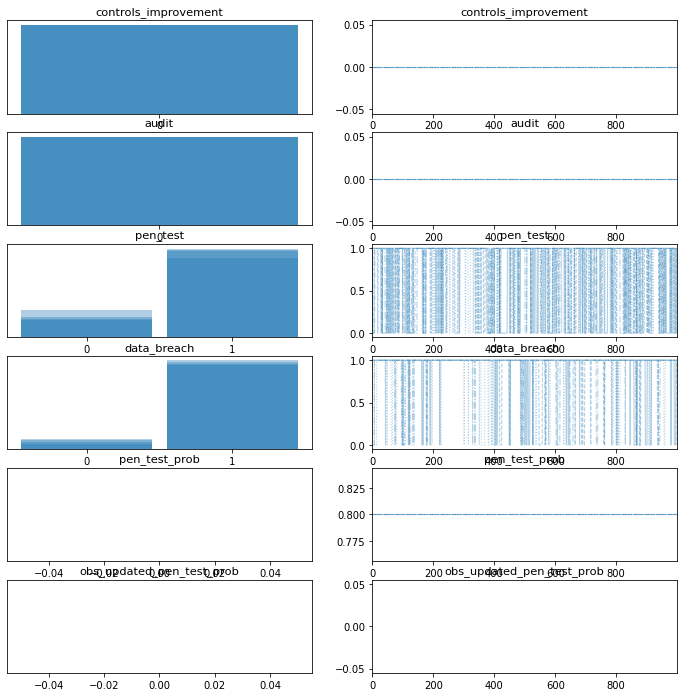

In [18]:
# Display results
pm.traceplot(trace)

Got error No model on context stack. trying to find log_likelihood in translation.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

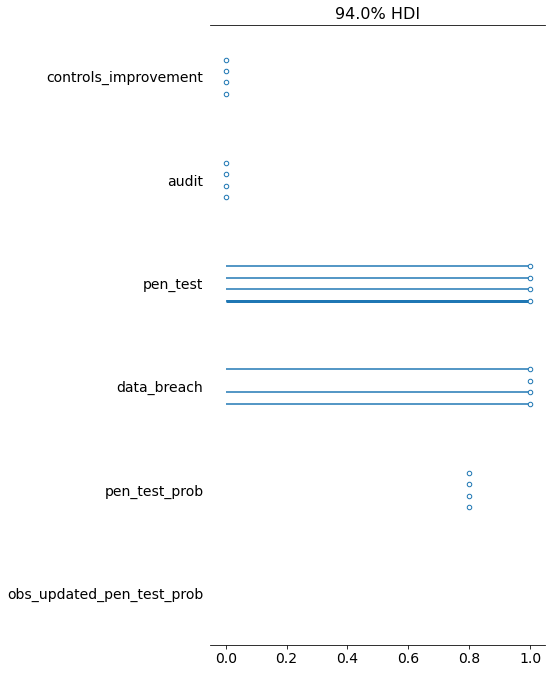

In [19]:
pm.forestplot(trace)

In [20]:
# Print the summary
summary = pm.summary(trace, var_names=['data_breach'])
print(summary)

Got error No model on context stack. trying to find log_likelihood in translation.


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
data_breach  0.916  0.277     0.0      1.0      0.011    0.008     645.0   

             ess_tail  r_hat  
data_breach     645.0   1.01  
